In [4]:
import numpy as np
import torch
from scipy.optimize.moduleTNC import minimize
from torch import Tensor
from numpy import ndarray
from scipy.spatial import Delaunay
from typing import Tuple, Union, Optional
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sympy import symbols, integrate, lambdify

set_t = {
    "dtype": torch.float32,
    "device": torch.device("cuda"),
}

/home/jorgejc2/anaconda3/envs/ray-casting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Function to define the unit cube vertices
def get_cube_vertices(x_L: Tensor, x_U: Tensor) -> ndarray:
    """
    Given the lower and upper bounds on the input domain, generate vertices in lexicographical order by using the cartesian product operator.
    :param x_L: Input lower bounds
    :param x_U: Input upper bounds
    :return:    Vertices in lexicographic order
    """
    x_L = x_L.reshape(1, -1)
    x_U = x_U.reshape(1, -1)
    cat_tensor = torch.cat((x_L, x_U), 0).permute(1, 0)
    points = torch.cartesian_prod(*cat_tensor)
    return points.detach().cpu().numpy()


# Function to define the faces of a unit cube
def unit_cube_faces():
    # Each face consists of 4 vertices (indices refer to the vertex array)
    return [[0, 1, 5, 4],  # Bottom face
            [2, 3, 7, 6],  # Top face
            [0, 1, 3, 2],  # Front face
            [4, 5, 7, 6],  # Back face
            [0, 2, 6, 4],  # Left face
            [1, 3, 7, 5]]  # Right face


def plot_plane(
        ax,
        normal: ndarray,
        D: float,
        xlim: list[Union[float, int]],
        ylim: list[Union[float, int]]
):
    """

    :param ax:      Graph plotting object
    :param normal:  Plane coefficients
    :param D:       Plane offset
    :param xlim:    Graph x limits
    :param ylim:    Graph y limits
    :return:
    """
    A, B, C = normal
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10), np.linspace(ylim[0], ylim[1], 10))
    zz = (D - A * xx - B * yy) / C
    ax.plot_surface(xx, yy, zz, alpha=0.5)


def plot_cube(ax, vertices, faces):
    """

    :param ax:          Graph plotting object
    :param vertices:    Cube vertex coordinates
    :param faces:       Index mask into vertices describing the face in clockwise order
    :return:
    """
    # Plot the cube's faces
    for face in faces:
        verts = [vertices[face]]
        ax.add_collection3d(Poly3DCollection(verts, alpha=0.2, edgecolor='k'))


def generate_cube_edges() -> list[Tuple[int, int]]:
    """
    These are the edges for vertices represented by their lexicographic order.
    :return:
    """
    edges = []
    num_vertices = 8  # 2^3 for a cube

    for v1 in range(num_vertices):  # Vertices represented as 0 to 7 (3-bit numbers)
        for bit in range(3):  # Flip each of the 3 bits (positions 0, 1, 2)
            v2 = v1 ^ (1 << bit)  # XOR to flip the 'bit'-th bit
            if v2 > v1:  # Ensure we only add each edge once
                edges.append((v1, v2))

    return edges


def plot_intersection(ax, vertices, normal, D):
    """

    :param ax:          Graph plotting object
    :param vertices:    Cube vertex coordinates
    :param normal:      Plane normal coefficients
    :param D:           Plane offset
    :return:
    """
    A, B, C = normal
    # Compute distance from each vertex to the plane
    distances = A * vertices[:, 0] + B * vertices[:, 1] + C * vertices[:, 2] - D

    # Identify vertices below and above the plane
    below = vertices[distances < 0]
    above = vertices[distances >= 0]

    # Plot intersection points
    ax.scatter(below[:, 0], below[:, 1], below[:, 2], color='r', label='Below Plane')
    ax.scatter(above[:, 0], above[:, 1], above[:, 2], color='b', label='Above Plane')


def calculate_intersection(edges: ndarray, normal: ndarray, D: float, verbose=False
                           ) -> Tuple[ndarray, ndarray, ndarray]:
    """

    :param edges:   Edge vertex pairs
    :param normal:  Plane normal coefficients
    :param D:       Plane offset
    :param verbose: Prints debugging logs
    :return:
    """
    # convert to Tensors
    edges = torch.tensor(edges, **set_t)
    normal = torch.tensor(normal, **set_t)
    batches = edges.shape[0]

    # For 3D boxes, batch = 12
    Vis = edges[:, 0, :].unsqueeze(2)  # (batch x 3 x 1)
    Vjs = edges[:, 1, :].unsqueeze(2)  # (batch x 3 x 1)
    e_ij = Vjs - Vis  # (batch x 3 x 1)
    normal_exp = normal.reshape(1, 1, -1).expand(batches, -1, -1)
    if verbose:
        print(f"Shape Vis: {Vis.shape}")
        print(f"Shape Vjs: {Vjs.shape}")
        print(f"Shape Eij: {e_ij.shape}")
        print(f"Shape Normal Expanded: {normal_exp.shape}")

    lambdas = (D - normal_exp.bmm(Vis)) / normal_exp.bmm(e_ij)
    lambdas = lambdas.squeeze()  # squeeze out singleton dimensions

    if verbose:
        print(f"Lambdas (num {len(lambdas)}): \n{lambdas}")

    # create an intersection mask; intersection only happens when lambda is in range [0,1]
    i_mask = torch.logical_and(0. <= lambdas, lambdas <= 1.)
    num_intersections = i_mask.to(dtype=torch.int).sum()

    if verbose:
        print(f"Intersection mask ({num_intersections}): {i_mask}")

    if num_intersections > 0:
        Vis_m = Vis.squeeze()[i_mask]  # (num inter. x 3)
        lambdas_m = lambdas.unsqueeze(1)[i_mask]  # (num inter. x 1)
        e_ij_m = e_ij.squeeze()[i_mask]  # (num inter. x 3)
        if verbose:
            print(f"Shape Vis_m: {Vis_m.shape}")
            print(f"Shape lambdas_m: {lambdas_m.shape}")
            print(f"Shape e_ij_m: {e_ij_m.shape}")
        intersection_pts = Vis_m + lambdas_m * e_ij_m
    else:
        intersection_pts = torch.empty((0, 3))

    if verbose:
        print(f"Intersection points (shape {intersection_pts.shape}): {intersection_pts}")

    # convert results back to numpy
    lambdas_np = lambdas.detach().cpu().numpy()
    intersection_mask_np = i_mask.detach().cpu().numpy()
    intersection_pts_np = intersection_pts.detach().cpu().numpy()

    return lambdas_np, intersection_mask_np, intersection_pts_np


def volume_of_tetrahedron(a: ndarray, b: ndarray, c: ndarray, d: ndarray):
    """
    Calculate the volume of a tetrahedron with vertices a, b, c, d.
    :param a:   Vertex 1 (numpy array)
    :param b:   Vertex 2 (numpy array)
    :param c:   Vertex 3 (numpy array)
    :param d:   Vertex 4 (numpy array)
    :return:    Volume of the tetrahedron
    """
    return np.abs(np.dot(a - d, np.cross(b - d, c - d))) / 6.0


def calculate_volume_above_plane(ax, vertices: ndarray, intersection_pts: ndarray, normal: ndarray, D: float, verbose = False):
    """
    Calculate the volume above the plane inside the cube.
    :param vertices:            Cube vertex coordinates
    :param intersection_pts:    Points of intersection between cube edges and plane
    :param normal:              Normal vector of the plane
    :param D:                   Plane offset
    :return:                    Volume above the plane inside the cube
    """

    A, B, C = normal
    # Compute distances of each vertex from the plane
    distances = A * vertices[:, 0] + B * vertices[:, 1] + C * vertices[:, 2] - D

    # Separate vertices above the plane
    above_vertices = vertices[distances >= 0]

    # Combine above vertices with intersection points to form the polyhedron
    polyhedron_vertices = np.vstack([above_vertices, intersection_pts])

    ## check tetrahedrons
    # Perform Delaunay tetrahedralization
    delaunay = Delaunay(polyhedron_vertices)

    # Extract the tetrahedrons (each row represents the indices of 4 vertices forming a tetrahedron)
    tetrahedrons = delaunay.simplices
    tetrahedron_vertices = polyhedron_vertices[tetrahedrons]

    # Display the tetrahedrons
    if verbose:
        print(f"Shape polyhedron vertices: {polyhedron_vertices.shape}")
        print("Tetrahedrons (vertex indices):")
        print(tetrahedrons)
        print(f"tetrahedron_vertices (shape {tetrahedron_vertices.shape}): \n{tetrahedron_vertices}")
    ## stop check

    total_volume = 0.0
    for i in range(len(tetrahedron_vertices)):
        a = tetrahedron_vertices[i, 0, :]
        b = tetrahedron_vertices[i, 1, :]
        c = tetrahedron_vertices[i, 2, :]
        ref_point = tetrahedron_vertices[i, 3, :]
        curr_volume = volume_of_tetrahedron(ref_point, a, b, c)
        total_volume += curr_volume
        if verbose:
            print(f"i {i + 1} | {curr_volume:.3f} | {total_volume:.3f}")

    # Plot each tetrahedron
    for tet in tetrahedrons:
        # Extract the tetrahedron vertices
        tet_vertices = polyhedron_vertices[tet]

        # List of faces, each face is defined by 3 vertices
        faces = [
            [tet_vertices[0], tet_vertices[1], tet_vertices[2]],
            [tet_vertices[0], tet_vertices[1], tet_vertices[3]],
            [tet_vertices[0], tet_vertices[2], tet_vertices[3]],
            [tet_vertices[1], tet_vertices[2], tet_vertices[3]]
        ]

        # Create the 3D polygon collection for the tetrahedron
        poly3d = Poly3DCollection(faces, alpha=0.3, edgecolor='k')

        # Add the collection to the plot
        ax.add_collection3d(poly3d)

    # Set plot limits
    ax.set_xlim([vertices[:, 0].min(), vertices[:, 0].max()])
    ax.set_ylim([vertices[:, 1].min(), vertices[:, 1].max()])
    ax.set_zlim([vertices[:, 2].min(), vertices[:, 2].max()])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Intersection Tetrahedrons (Total Volume {total_volume:.3f})")

    return total_volume

def visualize_cube_intersection_with_plane(x_L: Tensor, x_U: Tensor, normal: ndarray, D: float, verbose=False):
    """

    :param x_L:     Input lower bounds
    :param x_U:     Input upper bounds
    :param normal:  Plane normal coefficients
    :param D:       Plane offset
    :param verbose: Print debugging logs
    :return:
    """
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Define cube vertices and faces
    vertices = get_cube_vertices(x_L, x_U)
    edge_masks = generate_cube_edges()
    edges = vertices[edge_masks, :]
    faces = unit_cube_faces()

    if verbose:
        print(f"Vertices (num {len(vertices)}): \n{vertices}")
        print(f"Edges (num {len(edges)}): \n{edges}")

    lambdas, intersection_mask, intersection_pts = calculate_intersection(edges, normal, D, verbose)

    if len(intersection_pts > 0):
        # intersection occurs with the bounding box and the plane
        ax1.scatter(intersection_pts[:, 0], intersection_pts[:, 1], intersection_pts[:, 2], color='g',
                    label='Intersection Points')
        print(f"Intersection Points: \n{intersection_pts}")

    intersection_volume = calculate_volume_above_plane(ax2, vertices, intersection_pts, normal, D, verbose)
    print(f"Volume intersection: {intersection_volume}")
    print(f"Total volume: {(x_U - x_L).prod()}")

    # Plot the cube
    plot_cube(ax1, vertices, faces)

    # Plot the intersecting plane
    plot_plane(ax1, normal, D, [0, 1], [0, 1])

    # # Plot the intersection of the plane with the cube
    plot_intersection(ax1, vertices, normal, D)

    # Label the axes
    ax1.set_xlim([x_L[0], x_U[0]])
    ax1.set_ylim([x_L[1], x_U[1]])
    ax1.set_zlim([x_L[2], x_U[2]])
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax1.set_title("Bounding Box with Plane Intersection")

    ax1.legend()
    plt.show()

Intersection Points: 
[[0.  0.5 1. ]
 [0.5 0.  1. ]
 [0.  1.  0.5]
 [0.5 1.  0. ]
 [1.  0.  0.5]
 [1.  0.5 0. ]]
Volume intersection: 0.5
Total volume: 1.0


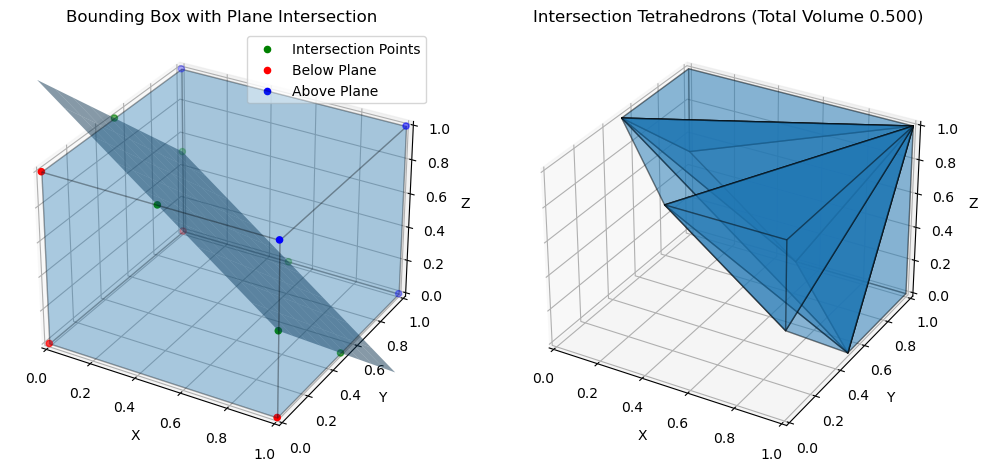

In [6]:
# plane equation <normal, x> + D = 0
normal = np.array([1, 1, 1])
D = 1.5

# input bounding box
x_L = torch.zeros(3)
x_U = torch.ones(3)

visualize_cube_intersection_with_plane(x_L, x_U, normal, D, False)

Below we show a very simply example of how a double integral may be turned into a lambda function by using the library *Sympy*. 
$$
\int_0^1 \int_0^x (ax^2 + y^2) dy dx = \frac{a}{4} + \frac{1}{12}
$$

$$
\frac{d}{da}\left[\int_0^1 \int_0^x (ax^2 + y^2) dy dx\right] = \frac{d}{da}\left[\frac{a}{4} + \frac{1}{12}\right] = \frac{1}{4}
$$
After the integral has been simplified and lambdified, it can be used for gradient ascent with respect to parameter $a$. 

It is possible that we will need to create a closed form solution for calculating the volume of each tetrahedron in the form of a double integral, and simplified with the help of Sympy. Once these functions are obtained, it is trivial to perform gradient ascent with respect to plane parameters $a,b,c,d$ for a plane of the form $ax + by + cz + d = 0$. The not so trivial part is figuring out how to turn the vertices of each tetrahedron above and synthesize an expression in the form of a double integral. 

Why did I use two lambda functions below? In implementation, the integral equations will be different on each iteration. 

a/4 + 1/12
a/5 + 1/12
a: 3.667 -> 4.659
Parameter a over iterations: 
[3.76666665 3.86547923 3.9649992  4.06381178 4.16329718 4.26210976
 4.36159706 4.46040964 4.55990839 4.65872097]
Loss over iterations (keep in mind that the loss function is swapped every iteration): 
[1.         0.83666664 1.04970312 0.87633318 1.09928632 0.91599274
 1.14886081 0.95565271 1.19843578 0.99531502]


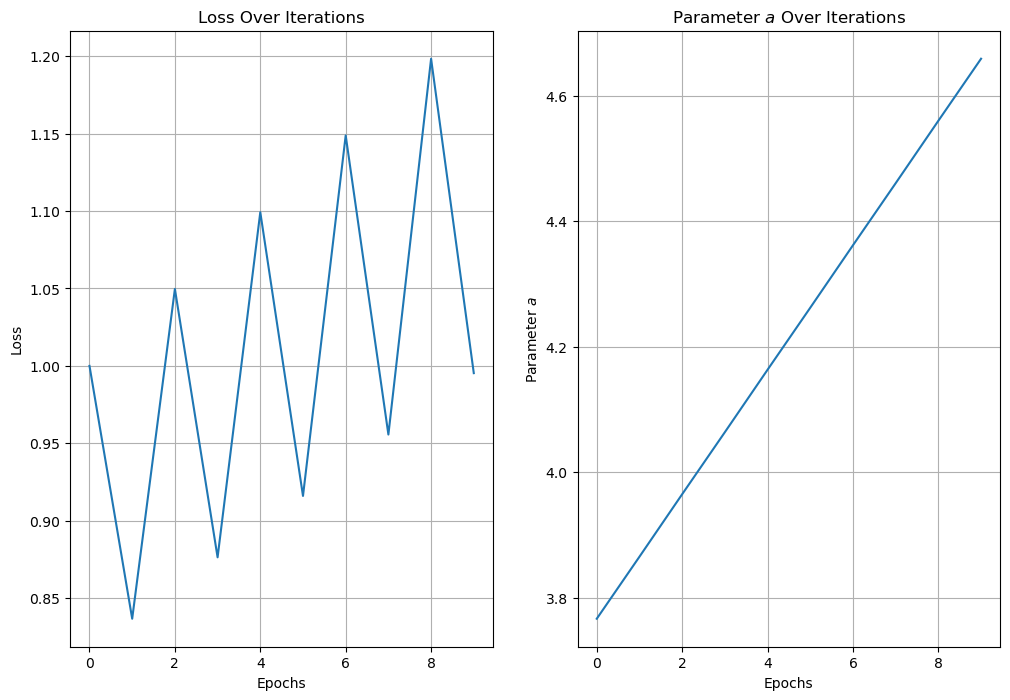

In [20]:
# Define the variables
x, y, a = symbols('x y a')

# Define the expression
expression = a*x**2 + y**2
expression_two = a*x**3 + y**2

# Compute the double integral symbolically
double_integral_one = integrate(integrate(expression, (y, 0, x)), (x, 0, 1))
double_integral_two = integrate(integrate(expression_two, (y, 0, x)), (x, 0, 1))
print(double_integral_one)
print(double_integral_two)

# Convert the symbolic expression into a Python function
integral_func_one = lambdify(a, double_integral_one)
integral_func_two = lambdify(a, double_integral_two)

# Now the function can be used for gradient ascent where a is now an optimizable tensor
a = torch.tensor(11/3, requires_grad=True)
old_a = a.detach().clone()
opt = torch.optim.Adam([a], lr=1e-1, maximize=True)
epochs = 10
losses = np.zeros(epochs)
a_values = np.zeros(epochs)
for i in range(10):
    if i % 2 == 0:
        loss_fn = integral_func_one
    else:
        loss_fn = integral_func_two
    opt.zero_grad()
    loss = loss_fn(a)  # For example, when a = 3
    losses[i] = loss.detach().item()
    loss.backward()
    opt.step()
    a_values[i] = a.detach().numpy()

# analyze results
print(f"a: {old_a.item():.3f} -> {a.detach().item():.3f}")
print(f"Parameter a over iterations: \n{a_values}")
print(f"Loss over iterations (keep in mind that the loss function is swapped every iteration): \n{losses}")
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Iterations")
plt.grid()
plt.subplot(122)
plt.plot(a_values)
plt.xlabel("Epochs")
plt.ylabel(r"Parameter $a$")
plt.title("Parameter $a$ Over Iterations")
plt.grid()
plt.show()